**How to run this script?**


1.   Navigate to "**Load the pretrained model**" section and set the path 
where you located the Bayesian models. 
2.   Navigate to "**Simulations**" section and provide a location where you want to save the model output. 
3. You are all set! Now you can run the script on Google Colab.



In [2]:
!pip3 install pyro-ppl==0.2.1

You should consider upgrading via the 'c:\users\tomva\onedrive\ku leuven\master theory and research\internship\rtnet\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

%matplotlib inline

In [4]:
# Check Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


**Load the data**

In [5]:
AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_path = os.path.join("..", "..", "data",'mnist-data')

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(mnist_path, train=True, download=True, transform=AlexTransform),
        batch_size=500, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(mnist_path, train=False, download=True, transform=AlexTransform),
        batch_size=1, shuffle=False)

**Define the model**

AlexNet structure

In [9]:
# AlexNet
class alexnet(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        # out = F.log_softmax(out, dim=1)

        return out

In [10]:
# Define Hyper parameters
img_size = 28 * 28
hidden_layer_size = 1024
num_classes = 10
net = alexnet().to(device)
# softmax
log_softmax = nn.LogSoftmax(dim=1)

Model function for pyro

In [11]:
def model(x_data, y_data):

    convLayer1_w = Normal(loc=torch.ones_like(net.conv1[0].weight), scale=torch.ones_like(net.conv1[0].weight))
    convLayer1_b = Normal(loc=torch.ones_like(net.conv1[0].bias), scale=torch.ones_like(net.conv1[0].bias))

    convLayer2_w = Normal(loc=torch.ones_like(net.conv2[0].weight), scale=torch.ones_like(net.conv2[0].weight))
    convLayer2_b = Normal(loc=torch.ones_like(net.conv2[0].bias), scale=torch.ones_like(net.conv2[0].bias))

    convLayer3_w = Normal(loc=torch.ones_like(net.conv3[0].weight), scale=torch.ones_like(net.conv3[0].weight))
    convLayer3_b = Normal(loc=torch.ones_like(net.conv3[0].bias), scale=torch.ones_like(net.conv3[0].bias))

    convLayer4_w = Normal(loc=torch.ones_like(net.conv4[0].weight), scale=torch.ones_like(net.conv4[0].weight))
    convLayer4_b = Normal(loc=torch.ones_like(net.conv4[0].bias), scale=torch.ones_like(net.conv4[0].bias))

    convLayer5_w = Normal(loc=torch.ones_like(net.conv5[0].weight), scale=torch.ones_like(net.conv5[0].weight))
    convLayer5_b = Normal(loc=torch.ones_like(net.conv5[0].bias), scale=torch.ones_like(net.conv5[0].bias))

    fc1Layer_w = Normal(loc=torch.ones_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1Layer_b = Normal(loc=torch.ones_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))

    fc2Layer_w = Normal(loc=torch.ones_like(net.fc2.weight), scale=torch.ones_like(net.fc2.weight))
    fc2Layer_b = Normal(loc=torch.ones_like(net.fc2.bias), scale=torch.ones_like(net.fc2.bias))

    fc3Layer_w = Normal(loc=torch.ones_like(net.fc3.weight), scale=torch.ones_like(net.fc3.weight))
    fc3Layer_b = Normal(loc=torch.ones_like(net.fc3.bias), scale=torch.ones_like(net.fc3.bias))

    priors = {'conv1[0].weight': convLayer1_w, 
              'conv1[0].bias': convLayer1_b,
              'conv2[0].weight': convLayer2_w,
              'conv2[0].bias': convLayer2_b,
              'conv3[0].weight': convLayer3_w,
              'conv3[0].bias': convLayer3_b,
              'conv4[0].weight': convLayer4_w,
              'conv4[0].bias': convLayer4_b,
              'conv5[0].weight': convLayer5_w,
              'conv5[0].bias': convLayer5_b,
              'fc1.weight': fc1Layer_w, 
              'fc1.bias': fc1Layer_b,
              'fc2.weight': fc2Layer_w, 
              'fc2.bias': fc2Layer_b,
              'fc3.weight': fc3Layer_w, 
              'fc3.bias': fc3Layer_b}

    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    lhat = log_softmax(lifted_reg_model(x_data))

    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

Guide function for pyro

In [12]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    convLayer1w_mu    = torch.randn_like(net.conv1[0].weight)
    convLayer1w_sigma = torch.randn_like(net.conv1[0].weight)
    convLayer1w_mu_param    = pyro.param("convLayer1w_mu", convLayer1w_mu)
    convLayer1w_sigma_param = softplus(pyro.param("convLayer1w_sigma", convLayer1w_sigma))
    convLayer1_w = Normal(loc=convLayer1w_mu_param, scale=convLayer1w_sigma_param)

    # First layer bias distribution priors
    convLayer1b_mu    = torch.randn_like(net.conv1[0].bias)
    convLayer1b_sigma = torch.randn_like(net.conv1[0].bias)
    convLayer1b_mu_param    = pyro.param("convLayer1b_mu", convLayer1b_mu)
    convLayer1b_sigma_param = softplus(pyro.param("convLayer1b_sigma", convLayer1b_sigma))
    convLayer1_b = Normal(loc=convLayer1b_mu_param, scale=convLayer1b_sigma_param)

    # Second layer weight distribution priors
    convLayer2w_mu    = torch.randn_like(net.conv2[0].weight)
    convLayer2w_sigma = torch.randn_like(net.conv2[0].weight)
    convLayer2w_mu_param    = pyro.param("convLayer2w_mu", convLayer2w_mu)
    convLayer2w_sigma_param = softplus(pyro.param("convLayer2w_sigma", convLayer2w_sigma))
    convLayer2_w = Normal(loc=convLayer2w_mu_param, scale=convLayer2w_sigma_param)

    # Second layer bias distribution priors
    convLayer2b_mu    = torch.randn_like(net.conv2[0].bias)
    convLayer2b_sigma = torch.randn_like(net.conv2[0].bias)
    convLayer2b_mu_param    = pyro.param("convLayer2b_mu", convLayer2b_mu)
    convLayer2b_sigma_param = softplus(pyro.param("convLayer2b_sigma", convLayer2b_sigma))
    convLayer2_b = Normal(loc=convLayer2b_mu_param, scale=convLayer2b_sigma_param)

    # Third layer weight distribution priors
    convLayer3w_mu    = torch.randn_like(net.conv3[0].weight)
    convLayer3w_sigma = torch.randn_like(net.conv3[0].weight)
    convLayer3w_mu_param    = pyro.param("convLayer3w_mu", convLayer3w_mu)
    convLayer3w_sigma_param = softplus(pyro.param("convLayer3w_sigma", convLayer3w_sigma))
    convLayer3_w = Normal(loc=convLayer3w_mu_param, scale=convLayer3w_sigma_param)

    # Third layer bias distribution priors
    convLayer3b_mu    = torch.randn_like(net.conv3[0].bias)
    convLayer3b_sigma = torch.randn_like(net.conv3[0].bias)
    convLayer3b_mu_param    = pyro.param("convLayer3b_mu", convLayer3b_mu)
    convLayer3b_sigma_param = softplus(pyro.param("convLayer3b_sigma", convLayer3b_sigma))
    convLayer3_b = Normal(loc=convLayer3b_mu_param, scale=convLayer3b_sigma_param)

    # Fourth layer weight distribution priors
    convLayer4w_mu    = torch.randn_like(net.conv4[0].weight)
    convLayer4w_sigma = torch.randn_like(net.conv4[0].weight)
    convLayer4w_mu_param    = pyro.param("convLayer4w_mu", convLayer4w_mu)
    convLayer4w_sigma_param = softplus(pyro.param("convLayer4w_sigma", convLayer4w_sigma))
    convLayer4_w = Normal(loc=convLayer4w_mu_param, scale=convLayer4w_sigma_param)

    # Fourth layer bias distribution priors
    convLayer4b_mu    = torch.randn_like(net.conv4[0].bias)
    convLayer4b_sigma = torch.randn_like(net.conv4[0].bias)
    convLayer4b_mu_param    = pyro.param("convLayer4b_mu", convLayer4b_mu)
    convLayer4b_sigma_param = softplus(pyro.param("convLayer4b_sigma", convLayer4b_sigma))
    convLayer4_b = Normal(loc=convLayer4b_mu_param, scale=convLayer4b_sigma_param)

    # Fifth layer weight distribution priors
    convLayer5w_mu    = torch.randn_like(net.conv5[0].weight)
    convLayer5w_sigma = torch.randn_like(net.conv5[0].weight)
    convLayer5w_mu_param    = pyro.param("convLayer5w_mu", convLayer5w_mu)
    convLayer5w_sigma_param = softplus(pyro.param("convLayer5w_sigma", convLayer5w_sigma))
    convLayer5_w = Normal(loc=convLayer5w_mu_param, scale=convLayer5w_sigma_param)

    # Fifth layer bias distribution priors
    convLayer5b_mu    = torch.randn_like(net.conv5[0].bias)
    convLayer5b_sigma = torch.randn_like(net.conv5[0].bias)
    convLayer5b_mu_param    = pyro.param("convLayer5b_mu", convLayer5b_mu)
    convLayer5b_sigma_param = softplus(pyro.param("convLayer5b_sigma", convLayer5b_sigma))
    convLayer5_b = Normal(loc=convLayer5b_mu_param, scale=convLayer5b_sigma_param)

    # First fully connected layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1Layer_w = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param).independent(1)

    # First fully connected layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1Layer_b = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)

    # Second fully connected layer weight distribution priors
    fc2w_mu = torch.randn_like(net.fc2.weight)
    fc2w_sigma = torch.randn_like(net.fc2.weight)
    fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
    fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
    fc2Layer_w = Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param).independent(1)

    # Second fully connected layer bias distribution priors
    fc2b_mu = torch.randn_like(net.fc2.bias)
    fc2b_sigma = torch.randn_like(net.fc2.bias)
    fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
    fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
    fc2Layer_b = Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)

    # Third fully connected layer weight distribution priors
    fc3w_mu = torch.randn_like(net.fc3.weight)
    fc3w_sigma = torch.randn_like(net.fc3.weight)
    fc3w_mu_param = pyro.param("fc3w_mu", fc3w_mu)
    fc3w_sigma_param = softplus(pyro.param("fc3w_sigma", fc3w_sigma))
    fc3Layer_w = Normal(loc=fc3w_mu_param, scale=fc3w_sigma_param).independent(1)

    # Third fully connected layer bias distribution priors
    fc3b_mu = torch.randn_like(net.fc3.bias)
    fc3b_sigma = torch.randn_like(net.fc3.bias)
    fc3b_mu_param = pyro.param("fc3b_mu", fc3b_mu)
    fc3b_sigma_param = softplus(pyro.param("fc3b_sigma", fc3b_sigma))
    fc3Layer_b = Normal(loc=fc3b_mu_param, scale=fc3b_sigma_param)

    priors = {'conv1[0].weight': convLayer1_w, 
              'conv1[0].bias': convLayer1_b,
              'conv2[0].weight': convLayer2_w,
              'conv2[0].bias': convLayer2_b,
              'conv3[0].weight': convLayer3_w,
              'conv3[0].bias': convLayer3_b,
              'conv4[0].weight': convLayer4_w,
              'conv4[0].bias': convLayer4_b,
              'conv5[0].weight': convLayer5_w,
              'conv5[0].bias': convLayer5_b,
              'fc1.weight': fc1Layer_w, 
              'fc1.bias': fc1Layer_b,
              'fc2.weight': fc2Layer_w, 
              'fc2.bias': fc2Layer_b,
              'fc3.weight': fc3Layer_w, 
              'fc3.bias': fc3Layer_b}

    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

**Load the pretrained model**

In [13]:
model_path = os.path.join("..", "data", "Bayesian_models") # This should be the path where the models are located
saved_model_dict = torch.load(model_path + '\model_01.pt') # model #1 in the path
net.load_state_dict(saved_model_dict['model'])
guide = saved_model_dict['guide']
pyro.get_param_store().load(model_path + "\model_01_params.pt") # model #1 in the path

C:\Users\tomva\AppData\Local\Temp\ipykernel_29604\3762706408.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_dict = torch.load(model_path + '\model_01.pt') #

**Define utils**

In [14]:
def give_uncertainities(x, num_samples=1):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x).data, dim=1) for model in sampled_models]
    return yhats[0]

def compute_evidence(image):
    # image = image.unsqueeze(dim=0)
    y = give_uncertainities(image)
    return y

def post_decisional_confidence(choice, image, th, time_limit):
    total_post_evidence = 0
    rt = 0
    
    while (abs(total_post_evidence) < th) and (rt < time_limit):
        # Gather evidence
        post_evidence = torch.exp(compute_evidence(image))
        print(post_evidence)
        # Check which choice has the most evidence
        post_choice = torch.argmax(post_evidence)
        # If choice, increase evidence
        if post_choice == choice:
            total_post_evidence += post_evidence[0][post_choice]
        # If not choice, lower evidence for choice
        else:
            total_post_evidence -= post_evidence[0][post_choice]
        rt += 1 # increase sampling step
        print(total_post_evidence)
    # Determine confidence from total_post_evidence level
    confidence = (total_post_evidence + th) / (2*th) # distance from lower threshold bound / distance two bounds
    return confidence
        

def compute_confidence(evidence):
    conf = torch.exp(evidence)
    conf = conf / torch.sum(conf) # Do these two operations not amount to a softmax (exp(a_i)/sum(exp(a_i)??
    conf_diff = conf.sort().values[0][-1] - conf.sort().values[0][-2]
    return conf_diff, conf


def decide(image, threshold=10, post_threshold=5, time_limit=5):
    rt = 0
    max_evidence, total_evidence = 0, 0
    while max_evidence < threshold:
      evidence = torch.exp(compute_evidence(image)) # These are softmax predictions (e^log_softmax = softmax)
      total_evidence = total_evidence + evidence # evidence only increases
      max_evidence = torch.max(total_evidence)
      rt = rt + 1 # Increase sampling step
    choice = torch.argmax(total_evidence) 
    confidence = post_decisional_confidence(choice, image, th=post_threshold, time_limit=time_limit) # enter post-decisional timeframe and derive confidence
    return int(choice.cpu().numpy()), rt, float(confidence.cpu().numpy())

def save_df(index, Choice, RT, Confidence, Threshold, Noise, Labels, image_stats, path):
    # unpack image stats
    noise_max, noise_mean, image_max, image_mean, noisy_image_max, noisy_image_mean = image_stats

    simulations = {'mnist_index': index,
                   'choice': Choice,
                   'rt': RT,
                   'confidence': Confidence,
                   'threshold': Threshold,
                   'noise': Noise,
                   'true label': Labels,
                   'noise max': noise_max,
                   'noise mean': noise_mean,
                   'image max': image_max,
                   'image mean': image_mean,
                   'noisy_image max': noisy_image_max,
                   'noisy_image mean': noisy_image_mean}

    df = pd.DataFrame(simulations)
    df.to_csv(path)
    return df

**Check posterior distribution of parameters**

In [24]:
# First get parameter names
pyro.get_param_store().get_all_param_names()

dict_keys(['convLayer1w_mu', 'convLayer1w_sigma', 'convLayer1b_mu', 'convLayer1b_sigma', 'convLayer2w_mu', 'convLayer2w_sigma', 'convLayer2b_mu', 'convLayer2b_sigma', 'convLayer3w_mu', 'convLayer3w_sigma', 'convLayer3b_mu', 'convLayer3b_sigma', 'convLayer4w_mu', 'convLayer4w_sigma', 'convLayer4b_mu', 'convLayer4b_sigma', 'convLayer5w_mu', 'convLayer5w_sigma', 'convLayer5b_mu', 'convLayer5b_sigma', 'fc1w_mu', 'fc1w_sigma', 'fc1b_mu', 'fc1b_sigma', 'fc2w_mu', 'fc2w_sigma', 'fc2b_mu', 'fc2b_sigma', 'fc3w_mu', 'fc3w_sigma', 'fc3b_mu', 'fc3b_sigma', 'module$$$conv1.0.weight', 'module$$$conv1.0.bias', 'module$$$conv2.0.weight', 'module$$$conv2.0.bias', 'module$$$conv3.0.weight', 'module$$$conv3.0.bias', 'module$$$conv4.0.weight', 'module$$$conv4.0.bias', 'module$$$conv5.0.weight', 'module$$$conv5.0.bias'])

In [27]:
fc3_weight_mu = pyro.get_param_store().get_param("fc3w_mu")
fc3_weight_sigma =  pyro.get_param_store().get_param("fc3w_sigma")

tensor([[ 0.4269,  0.2199,  0.6058,  ...,  1.4239, -0.5070,  0.9471],
        [-1.0034,  0.1062, -0.3718,  ...,  0.5156,  0.2036, -2.2555],
        [ 0.4384, -1.6539,  0.3159,  ...,  0.5572,  2.3773,  1.1827],
        ...,
        [ 0.2677, -1.2532, -0.7256,  ..., -0.1818,  1.7933, -0.8401],
        [-1.2925,  0.4993,  1.8075,  ..., -1.2445,  0.1670, -0.3394],
        [ 2.2577,  0.7752,  0.8393,  ..., -1.8114,  0.2730,  1.1335]],
       device='cuda:0', requires_grad=True)

In [14]:
ev = 0.6

torch.manual_seed(42)

image, label = next(iter(test_loader))
noise_array = torch.rand(image.shape) * image.max() # multiply with the max value to make the noise as strong as the original image.
# Compute final image
noisy_image = ev*image + (1-ev)*noise_array

choice, rt, confidence = decide(noisy_image.to(device), threshold=5, post_threshold=5, time_limit=5)
confidence


tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
tensor(1., device='cuda:0')
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
tensor(2., device='cuda:0')
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
tensor(3., device='cuda:0')
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
tensor(4., device='cuda:0')
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')
tensor(3., device='cuda:0')


0.800000011920929

0.6000000238418579

**Simulations**

In [1]:
threshold_levels = [3]

save_path = 'results/noise_level_sims.csv' # path to where you want to save the output
all_index, all_choice, all_rt, all_confidence, all_threshold, all_labels, all_ef = [], [], [], [], [], [], []

# image statistics lists
noise_max, noise_mean, image_max, image_mean, noisy_image_max, noisy_image_mean = [], [], [], [], [], []

# Iterate across threshold levels.
for a in threshold_levels:
  print("Set the threshold to {}".format(str(a)))
  # Iterate across levels of evidence strength (ef=evidence factor). 0 = pure noise, 1 = pure evidence
  for ev in np.linspace(0, 1, 11): 
      # Evidence factor
      ev = round(ev, 1) # np.linspace can cause rounding errors.
      print('   Set the evidence level to {}'.format(str(ev)))
      for i, (image, label) in enumerate(test_loader):
        # Compute final image as a weighted blend between pure noise and the original image
        # Compute noise array
        noise_array = torch.rand(image.shape) * image.max() # multiply with the max value to make the noise as strong as the original image.
        # Compute final image
        noisy_image = ev*image + (1-ev)*noise_array
        choice, rt, confidence, _ = decide(noisy_image.to(device), threshold=a)
        all_index.append(i)
        all_choice.append(choice)
        all_rt.append(rt)
        all_confidence.append(confidence)
        all_threshold.append(a)
        all_ef.append(ev)
        all_labels.append(int(label.cpu().numpy()))

        # image and noise data
        noise_max.append(noise_array.max())
        noise_mean.append(noise_array.mean())
        image_max.append(image[image>0].max()) # Just take the positive non-zero values (the actual pixels belonging to the evidence)
        image_mean.append(image[image>0].mean())
        noisy_image_max.append(noisy_image.max())
        noisy_image_mean.append(noisy_image.mean())
        
        # Print progress after each 1000 images.
        if (i%1000)==0:
          print('           {}'.format(str(i)))
      
      # store image stats in single list
      all_image_stats = [noise_max, noise_mean, image_max, image_mean, noisy_image_max, noisy_image_mean]
      # Save to file.
      save_df(all_index, all_choice, all_rt, all_confidence, all_threshold, all_ef, all_labels, all_image_stats, save_path)

Set the threshold to 3


NameError: name 'np' is not defined

**Example images with noise**

Mean of noise: 1.4086344242095947
Max of noise: 2.8086278438568115
Image max value: 2.808758497238159
Image mean value of positive nonzero values: 1.5250030755996704
Image + noise, max: 2.8084497451782227
Image + noise, mean: 1.2553080320358276


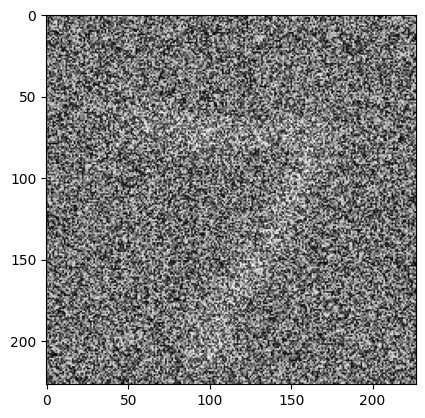

In [11]:
import matplotlib.pyplot as plt


image, label = next(iter(test_loader))

# Apply noise to image
p = 0.1

# The image becomes a blend of pure noise and the original image.
noise = torch.rand(image.shape)*image.max()
noisy_image = p*image + (1-p)*noise # multiply with the max value to make the noise as strong as the original image.
print(f"Mean of noise: {noise.mean()}")
print(f"Max of noise: {noise.max()}")
print(f"Image max value: {image.max()}")
print(f"Image mean value of positive nonzero values: {image[image>0].mean()}")
print(f"Image + noise, max: {noisy_image.max()}")
print(f"Image + noise, mean: {noisy_image.mean()}")

# Plot image
plt.imshow(noisy_image.squeeze(), cmap='gray')


In [132]:
for noise in np.linspace(0, 1, 11):
    print(round(noise, 1))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


TypeError: 'range' object is not an iterator